In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.stats import norm
import seaborn as sns

import os
os.chdir('/home/jupyter-colab-project/github/')

from prediction import *
from debiase import *

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.precision", 4)

### Coverage analysis

In [2]:
## use RCL data generation as an example 

## set up 
# number of products in each market 
J = 3 
# number of markets
M = 100
# number of non-price product features
K = 5
# parameters (mean and variance of each random coefficients)
params = [np.ones(K+2) , np.ones(K+2) * 0.5] 
# parameters of price
params[0][-1] = -1
# data generation for demand following rcl
dg = rcl  # mnl 
# delta for evaluating the effect of price change
delta = 0.01


In [3]:
## generate 100 random seeds (these are the seeds used for replication) 
np.random.seed(102666)
seed_list = np.random.choice(1000000, 100, replace=False)
seed_list

array([357409, 147442, 759978, 549771, 161756, 775466, 325401, 155680,
       399322, 582773, 356063, 130624, 882984, 916183, 784266, 447246,
       249366, 844921, 200302, 281658, 964930, 104203, 837427, 765775,
       412319, 563918, 783145, 620206, 246769, 468635, 147440, 398145,
       911726, 506965, 688369, 761019,  11693, 245782, 541848, 302682,
       922835, 794901, 333573, 650404,  32602, 128420, 358671, 530248,
       586726, 248392, 385817, 344729, 255930, 524650, 121945, 360292,
        61751, 912498, 305725,  18753, 575233, 481054, 430340, 857625,
        62724, 685801, 975127, 434134, 837012, 768948, 500797, 929812,
       347000, 653743, 969576, 130140, 877666, 797856, 723095, 721695,
       367248,  37581, 854434, 848326, 880946, 796192, 315609, 298983,
       753377,  57695, 226625, 271325, 152336, 890792, 703039,  97420,
       549461, 576667, 108212, 877857])

In [4]:
# RCL
rslt_rcl = []

for seed in seed_list[0:3]: ## in our paper, we use seed_list[0:100]
    set_seed(seed)
    true = true_theta(J, M, K, seed, dg, params,  delta)
    theta_hat, theta_sd = Inference(J, M, K, seed, dg, params, delta = 0.01)
    ci_l = theta_hat - 1.96 * theta_sd / np.sqrt(J * M)
    ci_u = theta_hat + 1.96 * theta_sd / np.sqrt(J * M)
    cover = (ci_l < true) & (ci_u > true)
    significant = ci_u < 0
    bias = theta_hat - true
    ci_l90 = theta_hat - 1.64 * theta_sd / np.sqrt(J * M )
    ci_u90 = theta_hat + 1.64 * theta_sd / np.sqrt(J * M )
    cover90 = (ci_l90 < true) & (ci_u90 > true)
    print(seed, cover, significant, bias, cover90)
    rslt_rcl.append([seed, theta_hat, theta_sd, true, ci_l, ci_u, cover, significant, bias])

357409 True True 3.501472713341282e-05 True
147442 True True -7.740656852768405e-05 True
759978 True True -9.099794862968652e-05 True


In [5]:
#rslt_rcl_df = pd.DataFrame(rslt_rcl, columns = ['seed', 'theta_hat', 'theta_sd', 'true', 'ci_l', 'ci_u', 'cover', 'significant', 'bias'])
#rslt_rcl_df.to_csv('results/debiase_rslt.csv')

In [6]:
# report coverage statistics
rslt_rcl_df = pd.read_csv('results/debiase_rslt.csv')
rslt_rcl_df[['true','cover','bias']].mean()

true    -1.3328e-03
cover    9.1000e-01
bias    -1.2898e-05
dtype: float64

## Comparison with the plug-in method

In [7]:
## RCL
J = 3
M = 100
K = 5

params = [np.ones(K+2) , np.ones(K+2) * 0.5] 
params[0][-1] = -1
dg = rcl 
delta = 0.01

rslt_rcl_nc = []

for seed in seed_list[0:3]:
    set_seed(seed)
    rslt = PlugIn_theta(J, M, K, seed, dg, params,  delta = 0.01)
    rslt_rcl_nc.append([item for sublist in rslt for item in sublist])
    print(rslt)


[[-0.0013334292, 0.0014379476]]
[[-0.0013833591, 0.0015712777]]
[[-0.001511665, 0.0015254867]]


In [8]:
#rslt_rcl_nc_df = pd.DataFrame(rslt_rcl_nc, columns = ['our_nc_hat', 'our_nc_sd'])
#rslt_rcl_nc_df.to_csv('results/plugin_rslt.csv')

## Plots

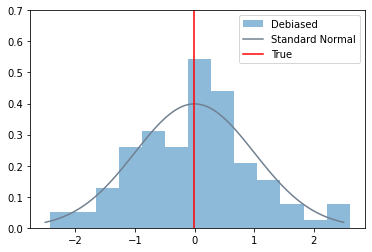

In [9]:
## debiased method
plt.hist((rslt_rcl_df['theta_hat'] - rslt_rcl_df['theta_hat'].mean())/rslt_rcl_df['theta_hat'].std(), 
         bins=13, alpha=0.5, label='Debiased', density=True)

## add std normal
x = np.linspace(-2.5, 2.5, 100)  # Range for x-axis
y = norm.pdf(x, 0, 1)  # PDF of the standard normal distribution
plt.plot(x, y, label='Standard Normal',color = 'slategray')

plt.axvline(rslt_rcl_df['true'].mean(),  linestyle='-', label='True', color = 'red')

# Show the plot with a legend
plt.legend(loc='upper right')
plt.ylim(0, 0.7)

plt.show()

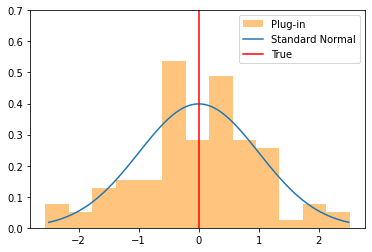

In [10]:
## plug-in method
rslt_rcl_nc_df = pd.read_csv('results/plugin_rslt.csv')

plt.hist((rslt_rcl_nc_df ['our_nc_hat'] -rslt_rcl_nc_df ['our_nc_hat'].mean())/rslt_rcl_nc_df ['our_nc_hat'].std(), 
         bins=13, alpha=0.5, label='Plug-in', density = True, color = 'darkorange') 
## add std normal
x = np.linspace(-2.5, 2.5, 100)  # Range for x-axis
y = norm.pdf(x, 0, 1)  # PDF of the standard normal distribution
plt.plot(x, y,  label='Standard Normal')

plt.axvline(rslt_rcl_df['true'].mean(),  linestyle='-', label='True', color = 'red')

# Show the plot with a legend
plt.legend(loc='upper right')
plt.ylim(0, 0.7)

plt.show()